Author: Jason Bono (jbono@fnal.gov)
Date: December 7, 2018
Last Edit: Feb 28, 2019. Minor cleanup and visualization added.

Purpose: High precision frequency extraction from NMR probe data

Description: A simple script that demonstrates a new technique developed by the author to calculate frequency with precision, without the need for envelope modeling.
Steps:
    1) Read in and preprocess the signal
    2)  Estimate the signal’s frequency using an FFT (used as initializer)
    3)  Scan the 2D phase space of the “Cosecant Transform” (CT) of the data, and find the frequency/phase at which the transformed data’s RMS is minimized
    
The “Cosecant Transform” essentially divides the entire signal by a pure sine wave with a given frequency and phase. When that frequency and phase match, the transformed signal reduces to the envelope of the signal. Small perturbations in frequency/phase cause the transformed values to explode, rapidly decreasing the similarity to envelope, and rapidly increasing the RMS.




In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# My modules
from freqlib import srate,cosecant_transform
from freqlib import scan_cosecant_transform, fft_peak

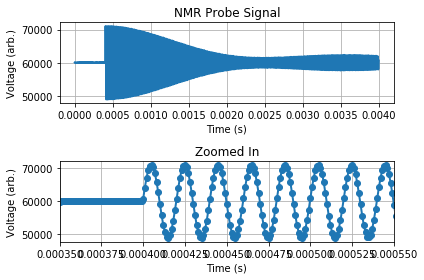

In [34]:
# Open the sensor data as a dataframe
# file_path = 'data/test2.txt'
file_path = 'data/Probe2Reading20.txt'


df = pd.read_csv(file_path,  delimiter = ',',comment='#', names=['Time','Voltage'])

# Convert the df to a numpy ndarray
data = df.values

# Fill 1d arrays with the first two columns of the
time = data[:,0]
signal = data[:,1]
# Plot the signal vs time
plt.subplot(2, 1, 1)
plt.plot(time,signal, '-', lw=2)
plt.title('NMR Probe Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (arb.)')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(time,signal, 'o-', lw=2)
plt.xlim(0.00035,0.00055)
plt.title('Zoomed In')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (arb.)')
plt.grid()
plt.tight_layout()
plt.show()
#print("dim:",signal.size,time.size)


In [35]:

# Remove the pedestal from the signal
signal = signal - np.mean(signal)

#Get the sample rate (in hz)
sample_rate = srate(time)
print("sample rate = ",sample_rate)

# Get the peak frequency in the fft
fft_result = fft_peak(signal,sample_rate)
freqs = fft_result[0]
power = fft_result[1]
base_frequency = fft_result[2]
print("FFT frequency = ",base_frequency)





sample rate =  999999.9999999997
FFT frequency =  49999.99999999998


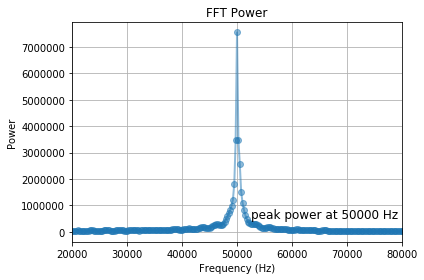

In [37]:
# Plot the FFT power spectrum
#plt.scatter(freqs,power)
plt.plot(freqs,power, 'o-', lw=2,alpha=0.5)
plt.xlim(20000,80000)
plt.title('FFT Power')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
#plt.ylim(-1, 1)
plt.grid()
s = "peak power at " + "%.0f" % base_frequency
s = s + " Hz"
plt.text(base_frequency*1.05, 500000, s, fontsize=12)
plt.tight_layout()

In [40]:
# Define the largest part of the signal as the start
max_value = max(signal)
signal_start_index  = np.argwhere(signal==max_value)[0][0]
print("max value = ",max_value," with index = ",signal_start_index)

# Set the amplitude threshold via the RMS of the pedestal
# To define the end of the pedestal, /
# move back three wavelengths from the start of the signal
pedestal_end_index = int(signal_start_index - 3*sample_rate/base_frequency)
pedestal_rms = np.sqrt(np.var(signal[:pedestal_end_index]))
print("pedestal rms = ",pedestal_rms)
#choose a signal to noise threshold
amp_threshold = 100*pedestal_rms #revert to 200


# Define the end of the signal
# First get local minima
# by defining an array of bools that are true if a point is larger than its neighbors
is_maxima_index = np.r_[True, signal[1:] > signal[:-1]] & np.r_[signal[:-1] > signal[1:], True]
# Find the true maxima, which are also above threshold
# print(is_maxima_index)
maxima = signal[(is_maxima_index) & (signal > amp_threshold)]

# print(maxima)



max value =  11084.02389452891  with index =  405
pedestal rms =  28.42868346072273


In [41]:
# Take the last instance where the signal was equal to its last defined maxima
signal_stop_index = np.argwhere(signal==maxima[-1])[-1][0]
# Finally define the good signal region
good_signal = signal[signal_start_index:signal_stop_index]
good_time = time[signal_start_index:signal_stop_index]

In [43]:
# Redo the FFT for the truncated signal
#base_frequency = fftpeak(good_signal,sample_rate)
fft_frequency = fft_peak(good_signal,sample_rate)[2]
base_frequency = fft_frequency
print("New fft frequency = ",base_frequency)

New fft frequency =  50034.27004797805


In [45]:
# Do the first scan
scan_result = scan_cosecant_transform(good_signal,sample_rate,base_frequency,0,30.3,np.pi)
#print("lowest_var=",scan_result[0],"lowest_var_f=",scan_result[1],"lowest_var_p=",scan_result[2])
base_frequency = scan_result[1]
base_phase = scan_result[2]
print("CT frequency = ",base_frequency)
print("CT phase = ",base_phase)
# Show the result
#transform_result = cosecant_transform(good_signal,sample_rate,scan_result[1],scan_result[2])
#transform_time = transform_result[2] + good_time[0]
#plt.plot(good_time,good_signal,'g',transform_time,transform_result[0],'ro')
#plt.show()





CT frequency =  50020.59004797804
CT phase =  -1.4660765716752369


In [46]:
# Do the second scan
scan_result = scan_cosecant_transform(good_signal,sample_rate,base_frequency,base_phase,10,np.pi/30.0)
#print("lowest_var=",scan_result[0],"lowest_var_f=",scan_result[1],"lowest_var_p=",scan_result[2])
base_frequency = scan_result[1]
base_phase = scan_result[2]
print("CT frequency = ",base_frequency)
print("CT phase = ",base_phase)

CT frequency =  50025.09004797804
CT phase =  -1.4905111812031575


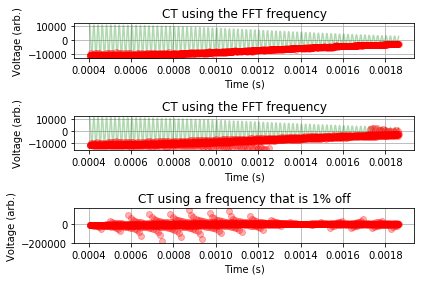

In [47]:
# Show the CT result
transform_result = cosecant_transform(good_signal,sample_rate,base_frequency,base_phase)
transform_time = transform_result[2] + good_time[0]
#plt.plot(good_time,good_signal,'g',transform_time,transform_result[0],'ro')
#plt.show()
plt.subplot(3, 1, 1)
plt.plot(good_time,good_signal,'g',transform_time,transform_result[0],'ro',alpha=0.3)
#plt.ylim(-11000,11000)
plt.title('CT using the FFT frequency')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (arb.)')
plt.grid()
# Show the CT result with the FFT frequency
transform_result = cosecant_transform(good_signal,sample_rate,fft_frequency,base_phase)
transform_time = transform_result[2] + good_time[0]
#plt.show()
plt.subplot(3, 1, 2)
plt.plot(good_time,good_signal,'g',transform_time,transform_result[0],'ro',alpha=0.3)
#plt.ylim(-11000,11000)
plt.title('CT using the FFT frequency')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (arb.)')
plt.grid()
# Show the CT result with a frequency that is off by 1%.
transform_result = cosecant_transform(good_signal,sample_rate,base_frequency*1.01,base_phase)
transform_time = transform_result[2] + good_time[0]
#plt.show()
plt.subplot(3, 1, 3)
plt.plot(good_time,good_signal,'g',transform_time,transform_result[0],'ro',alpha=0.3)
#plt.ylim(-11000,11000)
plt.title('CT using a frequency that is 1% off')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (arb.)')
plt.grid()
plt.tight_layout()
plt.show()